In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pprint
import matplotlib.pyplot as plt

# Part 1 - Processing 

It this part csvs are collected, merged and processed.
This example includes pre-Covid data. Some of the conclusions no longer applies. Prices might require adjusments according to price change. 

In [2]:
# read nadlan.gov csvs
# add your new csvs to the list and update name 
csv_names = [('ramat_alon.csv', 'Ramat Alon'), ('ramat_begin.csv', 'Ramat Begin'), ('ramat_almogi.csv', 'Ramat Almogi'),\
            ('ramat_sapir.csv', 'Ramat Sapir'), ('eistien.csv', 'Eistien'), ('karmelia.csv', 'Karmelia'),\
             ('ramat_golda.csv', 'Ramat_golda'), ('romema.csv', 'Romema'), ('ramat_eskol.csv', 'Eshkol')]

csv_list = []

for csv_file in csv_names:
    csv_ = pd.read_csv(f'data/gov/{csv_file[0]}')
    csv_['שכונה'] = csv_file[1]
    csv_list.append(csv_)

nadlan_df = pd.concat(csv_list, axis=0, ignore_index=True)
nadlan_df.head(5)

,קומות במבנה,שנת בנייה דירה,שנת בנייה מבנה,תאריך מכירה,כתובת,גוש חלקה -תת חלקה,סוג נכס,חדרים,קומה,"מ""ר",סכום,שכונה
0,3,1997,1997,08.07.2020,אזולאי יעקב השופט 5,11198-236-46,דירה בבית קומות,4.0,קרקע,82.17,"1,620,000",Ramat Alon
1,3,1988,1988,18.06.2020,חסידי אומות העולם 1,11879-6-52,דירה בבית קומות,4.5,שלישית,92.16,"1,650,000",Ramat Alon
2,6,1996,1996,16.06.2020,שלון 21,11880-19-7,דירה בבית קומות,3.0,רביעית,76.60,"1,410,000",Ramat Alon
3,2,1990,1990,11.06.2020,אלתר אליעזר 1,11879-22-11,דירה בבית קומות,3.0,שניה,75.57,"1,130,000",Ramat Alon
4,3,1991,1991,26.05.2020,סכנין אברהם 13,11880-16-37,דירה בבית קומות,2.0,שניה,59.21,"850,000",Ramat Alon


In [3]:
nadlan_df['תאריך מכירה'] = pd.to_datetime(nadlan_df['תאריך מכירה'])
nadlan_df['חדרים'] = nadlan_df['חדרים'].astype(float)

nadlan_df['סכום'].fillna('', inplace=True)
nadlan_df['סכום'] = nadlan_df['סכום'].astype(str)
nadlan_df['סכום'] = nadlan_df['סכום'].apply(lambda x: int(''.join(x.split(','))))

# missing value is -1
nadlan_df['קומות במבנה'].replace('-', -1, inplace=True)
nadlan_df['קומות במבנה'] = nadlan_df['קומות במבנה'].astype(float)

nadlan_df['מ"ר'].replace(' ', -1, inplace=True)
nadlan_df['מ"ר'] = nadlan_df['מ"ר'].astype(float)
nadlan_df['קומה'].value_counts()

ראשונה                  1103
שניה                     989
שלישית                   717
קרקע                     401
רביעית                   354
                        ... 
שניה ועליית גג             1
מרתף,קרקע,ראש'-שליש'       1
ראשונה,שניה ושלישית        1
שלישית מסד                 1
שישית,שביעית               1
Name: קומה, Length: 209, dtype: int64

In [4]:
# replace nan in address field
nadlan_df['כתובת'].fillna('', inplace=True)

In [5]:
# adding entrence floor and floors in the apartment 
# you may encouter higher floors - add them to the dict
floors_dict = {'שבע עשרה':17,'שמונה עשרה':18,'תשיעית':9,'מרתף':-1,'תשע עשרה':19,'עשרים':20,'אחת עשרה':11,'קרקע':0,'ראשונה':1,'שניה':2,'שתיים עשרה':12,'שלוש עשרה':13,'ארבע עשרה':14,'חמש עשרה':15,'שש עשרה':16,'שלישית':3,'רביעית':4, 'חמישית':5,'חמשית':5 ,'שישית':6,'מקלט':-1,'שביעית':7,'שמינית':8,'תשיעית':9,'שתים עשרה':12,'עמודים':0,'עשירית':10}

# unique phrases used....
spcial_floors_dict = {'אחת-עשרה':11,"מרתף,קרקע,ראש'-שליש'":0,'עמודים בקומה שניה':2, 'קומה 0':0,'עשירית אחת עשרה':0,'שתים עשרה שלוש עשרה':0, 'ראשונה,שניה ושלישית':1}

def find_minimal(floors, floors_dict=floors_dict):
    
    if floors in spcial_floors_dict.keys():
        return spcial_floors_dict[floors]
    
    missing_value = -6 # hopefuly not real
    
    if '+' in floors and ' ' in floors:
        fl = floors.split('+')
        return min([floors_dict[x] if x in floors_dict.keys() else missing_value for x in fl])
    

    if 'עשרה' in floors:
        return floors
    
    fl = floors.split('ו ') if 'ו ' in floors else None
    fl = floors.split('+') if '+' in floors else floors.split(' ') if ' ' in floors else [-6]
    
    return min([floors_dict[x] if x in floors_dict.keys() else missing_value for x in fl])

def count_floors(floors):
    
    if 'עשרה' in floors:
        return 1
    
    return len(floors.split('+')) if '+' in floors else len(floors.split(' ')) if ' ' in floors else 1
    
nadlan_df['קומת כניסה'] = nadlan_df['קומה'].apply(lambda x: floors_dict[x] if x in floors_dict.keys() else find_minimal(x))
nadlan_df['קומות בדירה'] = nadlan_df['קומה'].apply(lambda x: count_floors(x))
nadlan_df.loc[nadlan_df['קומת כניסה'] > nadlan_df['קומות במבנה'], ['קומות במבנה']] = nadlan_df.loc[nadlan_df['קומת כניסה'] > nadlan_df['קומות במבנה'], ['קומת כניסה']] 

In [6]:
nadlan_df['שנת בנייה מבנה'].replace('-', -1, inplace=True)
nadlan_df['שנת בנייה מבנה'] = nadlan_df['שנת בנייה מבנה'].astype(int)

nadlan_df['שנת בנייה דירה'].replace('-', -1, inplace=True)
nadlan_df['שנת בנייה דירה'] = nadlan_df['שנת בנייה דירה'].astype(int)

In [7]:
# fixing typo sums - no single apartemnt is sold in over 10MIL INS - In Haifa

nadlan_df.loc[nadlan_df["סכום"] > 10000000, "סכום"] = nadlan_df.loc[nadlan_df["סכום"] > 10000000, "סכום"].apply(lambda x: x/10)

# Part 2- Analysis

In this part:
- Filtering 
- A few examples of useful anaysis.

## Filtering 
Here we can filter according to *almost* all avilable fields to find relevant sales .
Then, we can examine the median and std of size and price according to neighborhood and filter to the desired room number.

In [8]:
nadlan_df['כתובת'].fillna(' ', inplace=True)

In [9]:
# filter according to address, rooms etc

s='אזולאי' # use '' for not filtering street
max_rooms = 5
min_rooms = 3
min_size = 70
max_enter = 2
min_date = nadlan_df['תאריך מכירה'].min()
max_sum = 7000000

min_year_apartment = 1930
min_year_building = 1930

max_building_floors = 4
max_enterance_floor = 4
esset_type = 'דירה בבית קומות'

temp_df = nadlan_df.loc[(nadlan_df['כתובת'].apply(lambda x: s in x)) & (nadlan_df['חדרים'] >= min_rooms)\
                        & (nadlan_df['חדרים'] <= max_rooms)& (nadlan_df['מ"ר'] >= min_size)\
                        & (nadlan_df['קומת כניסה'] >= max_enter) & (nadlan_df['תאריך מכירה'] >= min_date)\
                        & (nadlan_df['סכום'] <= max_sum) & (nadlan_df['שנת בנייה דירה'] >= min_year_apartment)\
                       & (nadlan_df['שנת בנייה מבנה'] >= min_year_building) & (nadlan_df['קומות במבנה'] <= max_building_floors)\
                       & (nadlan_df['קומת כניסה'] <= max_enterance_floor) & (nadlan_df['סוג נכס'] == esset_type)]

temp_df

,קומות במבנה,שנת בנייה דירה,שנת בנייה מבנה,תאריך מכירה,כתובת,גוש חלקה -תת חלקה,סוג נכס,חדרים,קומה,"מ""ר",סכום,שכונה,קומת כניסה,קומות בדירה
21,3.0,1997,1997,2019-09-18,אזולאי יעקב השופט 5,11198-236-45,דירה בבית קומות,3.0,שלישית,74.37,1490000.0,Ramat Alon,3,1
60,3.0,1997,1997,2018-04-11,אזולאי יעקב השופט 7,11198-237-2,דירה בבית קומות,3.0,שניה,73.00,1280000.0,Ramat Alon,2,1


In [10]:
# median and std of prices according to the number of rooms and neighberhood - last 5 years

# filter according to desired room number
rooms = 4 

nadlan_df.loc[(nadlan_df['תאריך מכירה'] >= pd.to_datetime(0, unit='D',origin=pd.Timestamp('2015-01-01'))) &\
              (nadlan_df['חדרים'] == rooms) & (nadlan_df['חדרים'] > 0), ['מ"ר','סכום','חדרים','שכונה']].groupby(['חדרים','שכונה']).agg(['median','std']).copy()


# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     print(agg_df)

מ"ר                  סכום               
                     median        std     median            std
חדרים שכונה                                                     
4.0   Eistien        88.760  12.696386  1342500.0  279489.132075
      Eshkol         96.000  13.290979  1468000.0  311109.591407
      Karmelia       94.150  14.697204  1790000.0  502926.987540
      Ramat Almogi  106.600  12.310637  1740000.0  394193.873946
      Ramat Alon     87.100   9.976539  1480000.0  252875.615070
      Ramat Begin    93.930  11.073078  1600000.0  417161.682841
      Ramat Sapir    87.000   4.451031  1340000.0  154488.536023
      Ramat_golda   101.295   9.740541  1792500.0  473521.283362
      Romema         89.200  13.262029  1362500.0  315675.845141

## Analysis

#### Prices over time
As shown below, sale price can be very noisy, there are outliars in both directions. In order to assess a reasonable price, its best to aggregate multiple sales. The second figure, depicts a clearer picture of the prices rise in the last 20 years. 

However, when we zoom-in to the last 5 years we see a relatively small change. So, for general trends we will leverage the entire data, but to assess a more reasonable price we can focus on the **last 5 years**.  

In [11]:
nadlan_df = nadlan_df.rename(columns={'תאריך מכירה':'Date','כתובת':'Address', 'גוש חלקה -תת חלקה':'Lot', 'סוג נכס':'Type','חדרים':'Rooms', 'מ"ר':'Size (m^2)', 'קומה':'Floor', 'קומת כניסה':'Enterance Floor', 'סכום':'Sum', 'שכונה':'Neighborhood','שנת בנייה דירה':'Apartment Year','קומות במבנה':'Building Hight'})

In [12]:
# other building types - remove from dataset - can be used in a different analysis
other_types = ['קרקע למגורים', 'חנות','משרד','מחסנים', 'בניני ציבור', 'תעשיה']

nadlan_df['other'] = nadlan_df.apply(lambda x: x.Type in other_types, axis=1)
nadlan_df = nadlan_df.loc[~nadlan_df.other]
nadlan_df.drop(columns=['other'], inplace=True)

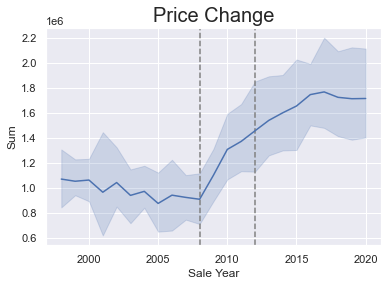

In [13]:
nadlan_df['Sale Year'] = nadlan_df['Date'].dt.year
d = nadlan_df.loc[(nadlan_df.Rooms > 3) & (nadlan_df.Rooms <= 5)].groupby(['Rooms', 'Sale Year']).mean().reset_index()

# sns.set_style("darkgrid")
sns.set(font_scale=1)
plt.axvline(2008, 0,2.2, color='grey', linestyle='--')
plt.axvline(2012, 0,2.2, color='grey', linestyle='--')

chart = sns.lineplot('Sale Year', 'Sum', data=d);

# plt.xticks(rotation=70);
chart.set_title("Price Change", fontsize=20);
plt.savefig('Price_change.png', dpi=200)


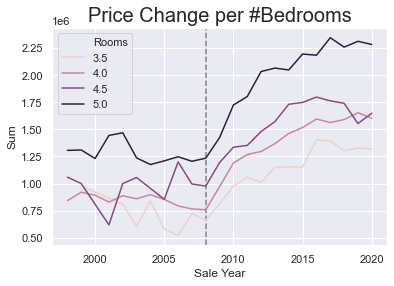

In [14]:
# median price change accroding to the number of rooms

nadlan_df['Sale Year'] = nadlan_df['Date'].dt.year
d = nadlan_df.loc[(nadlan_df.Rooms > 3) & (nadlan_df.Rooms <= 5)].groupby(['Rooms', 'Sale Year']).mean().reset_index()

# sns.set_style("darkgrid")
sns.set(font_scale=1)
plt.axvline(2008, 0,2.2, color='grey', linestyle='--')

chart = sns.lineplot('Sale Year', 'Sum', hue='Rooms', data=d);
# plt.xticks(rotation=70);
chart.set_title("Price Change per #Bedrooms", fontsize=20);
plt.savefig('Price_change_bedroom.png', dpi=200)


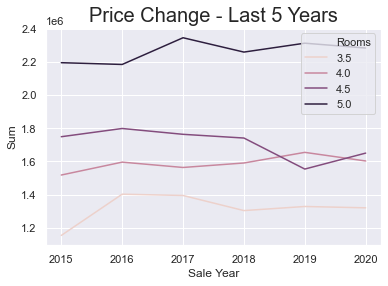

In [15]:
# Zoom-in median price change accroding by room number - last 5 years are stable

d = nadlan_df.loc[(nadlan_df['Sale Year'] >= 2015) & (nadlan_df.Rooms > 3) & (nadlan_df.Rooms <= 5)].groupby(['Rooms', 'Sale Year']).mean().reset_index()

chart = sns.lineplot('Sale Year', 'Sum', hue='Rooms', data=d);
chart.set_title("Price Change - Last 5 Years", fontsize=20);

**Changing Prices Note:** if the prices have change (usually upwards..) use means delta to adjust. 

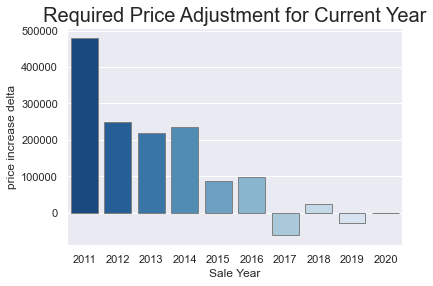

In [55]:
# type params

rooms = 5
current_year = 2020
start_year = 2010
d = nadlan_df.loc[(nadlan_df.Rooms == rooms)&(nadlan_df['Sale Year'] > start_year)].groupby(['Sale Year']).mean().reset_index()


current_year_price = d.loc[(d['Sale Year'] == current_year), 'Sum'].iloc[0]
d['price increase delta'] = d.Sum.apply(lambda x: current_year_price - x)

# sns.set_style("darkgrid")
sns.set(font_scale=1)

chart = sns.barplot('Sale Year', 'price increase delta',  data=d, palette="Blues_r",  edgecolor = 'grey');
# plt.xticks(rotation=70);
chart.set_title("Required Price Adjustment for Current Year", fontsize=20);
plt.savefig('Price_change_bedroom.png', dpi=200)

### Variation between neighborhoods

It is apparent that prices differ among neighborhoods. The reasons may vary - some are related to general neighborhood features like location or facilities, and some are related to apartment's features such as build year, building type, the presence of a yard or a belcony etc.

We can also see a significant differnces in new apartments vs. old apartments. In recent years, TAMA38 projects have emerged in the older neighborhoods. The exsitence of such projects is identifiable by the large variation in apartments' build year in a certain neighberhood. TAMA38 projects have also contributed to the rise in (most likely) 5 bedrooms apartments in the same neighborhoods since they entail an addition of an elevator, balconies and shelters to the building.

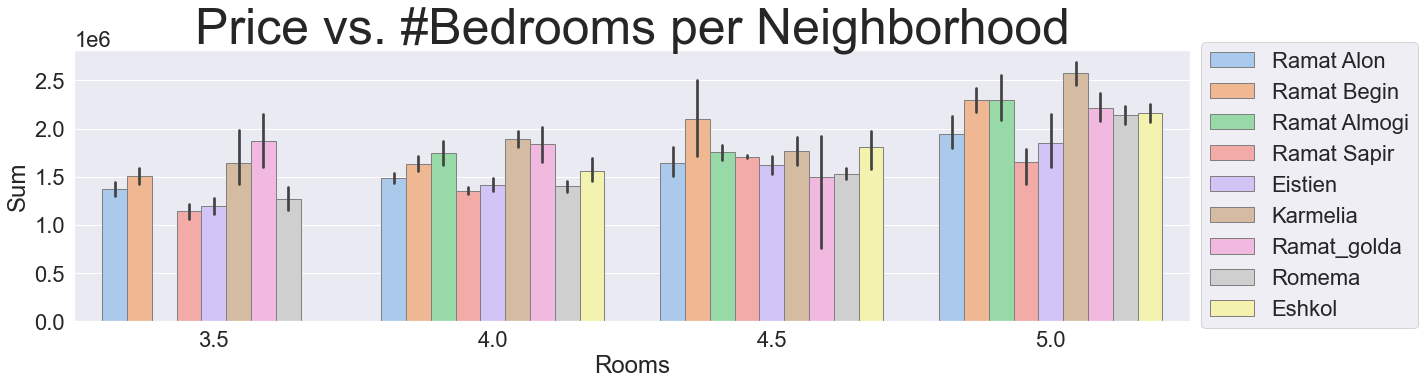

In [16]:
# filter according to room number / with or without last 5 years filter
min_rooms = 3
max_rooms = 5 
last_five_years = True

year = 2015 if last_five_years else 1990
d = nadlan_df.loc[(nadlan_df['Sale Year'] >= year)& (nadlan_df.Rooms > min_rooms)&(nadlan_df.Rooms <= max_rooms) & (nadlan_df['Date'] >= pd.to_datetime(0, unit='D',origin=pd.Timestamp('2015-01-01'))) & (nadlan_df['Rooms'] > 0), ['Enterance Floor','Sum','Rooms','Neighborhood']]

plt.figure(figsize=(20,5))
sns.set(font_scale=2)
g = sns.barplot(x = 'Rooms', y = 'Sum', hue = 'Neighborhood', data = d,
            palette = 'pastel', edgecolor = 'grey');
# gnuplot2
g.legend(loc='center left', bbox_to_anchor=(1, 0.5));
g.set_title("Price vs. #Bedrooms per Neighborhood", fontsize=50);
plt.savefig('Price vs. #Bedrooms per Neighborhood.png', dpi=200, bbox_inches="tight")


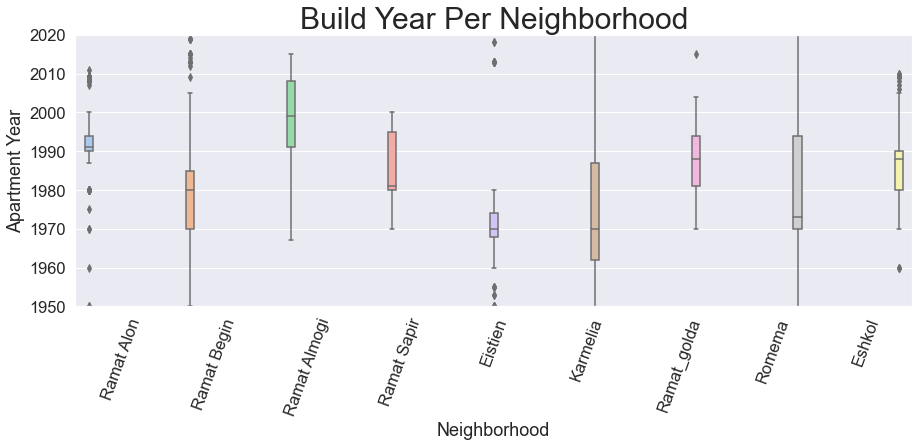

In [17]:
# Build year per neighborhood
nadlan_df['Apartment Year'].astype(int)
nadlan_df['build_year'] = nadlan_df['Apartment Year'].apply(lambda x: pd.to_datetime(0, unit='D',origin=pd.Timestamp(f'{x}-01-01')) if x > 0 else pd.to_datetime(0, unit='D',origin=pd.Timestamp(f'{2009}-01-01')))

nadlan_df['is_new'] = nadlan_df['Date'] - nadlan_df['build_year'] < pd.Timedelta('1825 days') 
sns.set(font_scale=1.5)

plt.figure(figsize=(15,5));
# Karmelia's build year is mostlt undocumeted for some reason
ax = sns.boxplot(x="Neighborhood", y='Apartment Year', hue="Neighborhood", palette="pastel", data=nadlan_df)
ax.set_ylim([1950, 2020]);
ax.set_title("Build Year Per Neighborhood", fontsize=30);
plt.xticks(rotation=70);

ax.legend_.remove()

plt.savefig('Build Year Per Neighborhood.png', dpi=200, bbox_inches="tight")


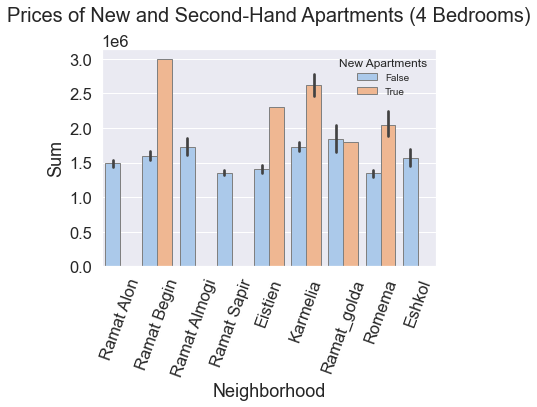

<Figure size 7200x360 with 0 Axes>

In [18]:
# median and std of prices of new vs. old appertments according to neighberhood - last 5 years
# Current filerting is for apartments only! - for a yard apartments change filter 

ap_type = "דירה בבית קומות" # alternativly try - "דירת גן"

d = nadlan_df.loc[(nadlan_df['Date'] >= pd.to_datetime(0, unit='D',origin=pd.Timestamp('2015-01-01'))) & (nadlan_df['Rooms'] > 0)& (nadlan_df['Type'] == ap_type)& (nadlan_df['Rooms'] == 4)]
g =sns.barplot(x = 'Neighborhood', y = 'Sum', hue = 'is_new', data = d,
            palette = 'pastel', edgecolor = 'grey')
plt.xticks(rotation=70);
sns.set(font_scale=0.9);
# g.legend(loc='center left', bbox_to_anchor=(1, 0.5));

g.legend(loc='upper right', frameon=False, title= "New Apartments")
g.set_title("Prices of New and Second-Hand Apartments (4 Bedrooms)", fontsize=20, y=1.1);

plt.figure(figsize=(100,5));


nadlan_df.loc[(nadlan_df['Date'] >= pd.to_datetime(0, unit='D',origin=pd.Timestamp('2015-01-01'))), ['Enterance Floor','Sum','Rooms','Size (m^2)','Neighborhood','is_new']].groupby(['Neighborhood','is_new']).median()
fig1 = plt.gcf()
fig1.savefig('PriceDifferencebetweenNewandSecondHandApartments.png', dpi=200, bbox_inches="tight")


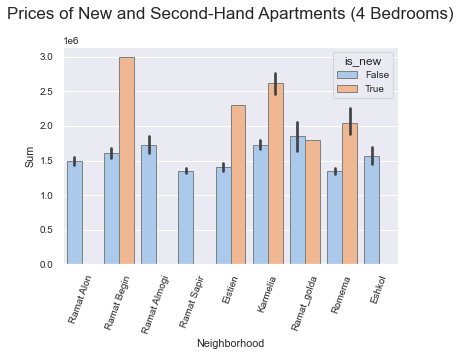

In [19]:
nadlan_df.loc[(nadlan_df['Date'] >= pd.to_datetime(0, unit='D',origin=pd.Timestamp('2015-01-01')))&(nadlan_df.Rooms==4), ['Enterance Floor','Sum','Rooms','Size (m^2)','Neighborhood','is_new']].groupby(['Neighborhood','is_new']).median()
g =sns.barplot(x = 'Neighborhood', y = 'Sum', hue = 'is_new', data = d,
            palette = 'pastel', edgecolor = 'grey')
plt.xticks(rotation=70);
sns.set(font_scale=0.9);
g.set_title("Prices of New and Second-Hand Apartments (4 Bedrooms)", fontsize=17, y=1.1);

plt.savefig('PriceDifferencebetweenNewandSecondHandApartments.png', dpi=200, bbox_inches="tight")


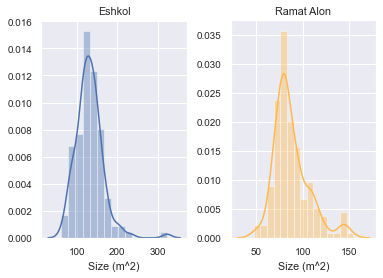

In [20]:
# Apartment distribution per neighborhood 
# select neighborhoods to compare
n1 = "Eshkol"
n2 = "Ramat Alon"

d1 =nadlan_df.loc[(nadlan_df['Date'] >= pd.to_datetime(0, unit='D',origin=pd.Timestamp('2015-01-01')))&(nadlan_df.Rooms>0) & (nadlan_df.Neighborhood == n1)]
d2 =nadlan_df.loc[(nadlan_df['Date'] >= pd.to_datetime(0, unit='D',origin=pd.Timestamp('2015-01-01')))&(nadlan_df.Rooms>0) & (nadlan_df.Neighborhood == n2)]

fig, axs = plt.subplots(1,2)
# d2.Rooms.hist(ax=axs[1], color='#ffcc80');
axs[0].set_title(f"{n1}")
axs[1].set_title(f"{n2}")
plt.subplots_adjust(wspace=0.3)
g = sns.distplot(d1['Size (m^2)'], bins=15, ax=axs[0]);
g2 = sns.distplot(d2['Size (m^2)'], bins=15, color='#ffb84d',  ax=axs[1] );

plt.savefig('size_hist.png', dpi=200, bbox_inches="tight")

# d2.plot(kind='hist', x='Rooms', color='red', ax=axs[1]);


### Apartment's Floor

Apartment's floor is correlated with price and not just with respect to number of stairs - penthouse apartments are also more expensive.
In Haifa most of the buildings cosist of 2-3 floors, some of them has 4-5 floors (TAMAS for example) and the rest are high buildings. 

Note that:
- Most of 3-storeys building have no elevator so there's a differnce between floors. 
- 4th floor in a 4-storeys buildings is likely a TAMA38.
- In tall apartment buildings the lower floors are cheaper from the upper floors.
- Apartments are cheaper in lower floors of tall apartment buildings than in the lower buildings where the stairs might be a factor.

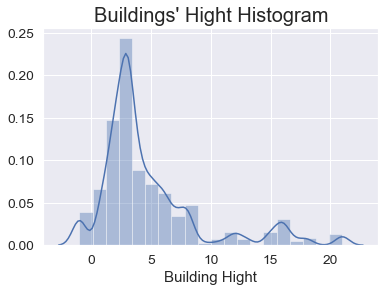

In [21]:
# Buildings' hight

n = '' # use '' for no filter
sns.set(font_scale=1.25);
g = sns.distplot(nadlan_df.loc[nadlan_df['Neighborhood'].apply(lambda x: n in x)]['Building Hight'], bins=20 );
g.set_title("Buildings' Hight Histogram", fontsize=20);

plt.savefig('Buildings_Hight_Histogram.png', dpi=200, bbox_inches="tight")


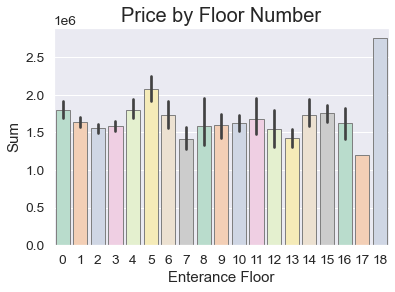

In [22]:
# price by floor number

last_five_years = True

year = 2015 if last_five_years else 1990

d = nadlan_df.loc[(nadlan_df['Sale Year'] >= year) & (nadlan_df['Rooms'] > 0) & (nadlan_df['Enterance Floor'] >= 0), ['Enterance Floor','Sum','Rooms','Neighborhood']]
sns.set(font_scale=1.25);

g =sns.barplot(x = 'Enterance Floor', y = 'Sum',  data = d,
            palette = 'Pastel2', edgecolor = 'grey')
g.set_title("Price by Floor Number", fontsize=20);


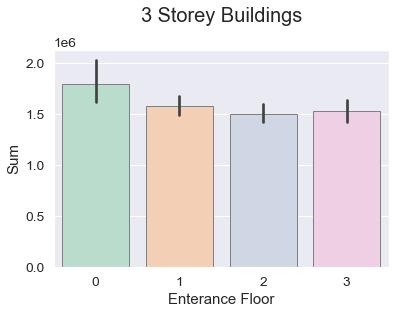

In [23]:
# same only for less than 4 floors

d = nadlan_df.loc[  (nadlan_df['Building Hight'] == 3) &(nadlan_df['Sale Year'] >= year) & (nadlan_df['Rooms'] > 0) & (nadlan_df['Enterance Floor'] >= 0), ['Enterance Floor','Sum','Rooms','Neighborhood']]
sns.set(font_scale=1.25);

g =sns.barplot(x = 'Enterance Floor', y = 'Sum',  data = d,
            palette = 'Pastel2', edgecolor = 'grey')
g.set_title("3 Storey Buildings", fontsize=20, y=1.1);

plt.savefig('Prices_in_Low_Buliding_for_4Bedrooms_3', dpi=200, bbox_inches="tight")


False    3751
True     1692
Name: tall, dtype: int64


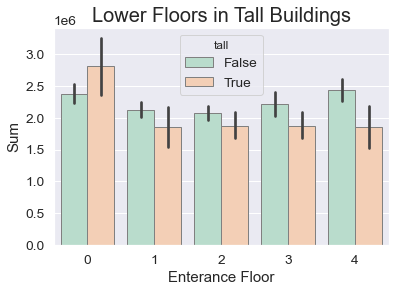

In [24]:
nadlan_df['tall'] = [False]*len(nadlan_df)
nadlan_df.loc[nadlan_df['Building Hight'] > 4, 'tall'] = True
print(nadlan_df['tall'].value_counts())
d = nadlan_df.loc[(nadlan_df['Sale Year'] >= year) & (nadlan_df['Rooms'] > 0) & (nadlan_df['Rooms'] == 5)& (nadlan_df['Enterance Floor'] <= 4) & (nadlan_df['Enterance Floor'] >= 0), ['Enterance Floor','Sum','Rooms','Neighborhood','tall']]
sns.set(font_scale=1.25);

g =sns.barplot(x = 'Enterance Floor', y = 'Sum',  data = d,
            palette = 'Pastel2', edgecolor = 'grey', hue='tall')
g.set_title("Lower Floors in Tall Buildings", fontsize=20);
plt.savefig('Lower_Floors_in_Tall_Buildings', dpi=200, bbox_inches="tight")


### TAMA38 buildings
The following reflects the price difference in second hand appartments in buildings after TAMA38. 
Please note: Not all not TAMA38 appartments are old. Some of the building didn't have TAMA8 because they are relatively new which also. A more careful filtering is according to build year (let's say <1990) which yeilds a more accurate result.

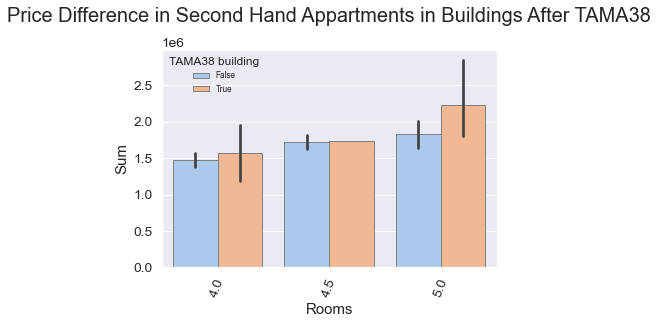

In [25]:
# find appartments in TAMA38 buildings
nadlan_df.build_year = nadlan_df.build_year.apply(lambda x: x.year)

nadlan_df['tama_apartment'] = nadlan_df.apply(lambda x: x['שנת בנייה מבנה'] != x['Apartment Year'], axis=1)
new_ap = nadlan_df.loc[nadlan_df.tama_apartment, ['Address','build_year']].drop_duplicates()
new_ap.set_index('Address', inplace = True)
new_ap = new_ap.to_dict()['build_year']

# appartments in TAMA38 , axis=1
nadlan_df['tama_building'] = False
nadlan_df.loc[~(nadlan_df.is_new), 'tama_building'] = nadlan_df.loc[~(nadlan_df.is_new)].apply(lambda x: (x.Address in new_ap.keys()) and (x['Sale Year'] >= new_ap[x.Address]), axis=1)
nadlan_df.loc[nadlan_df.Address == '', 'tama_building'] = False
# # filter build year
build_year = 1990 # no filter is = 2020

d = nadlan_df.loc[(nadlan_df['Date'] >= pd.to_datetime(0, unit='D',origin=pd.Timestamp('2015-01-01'))) & (~nadlan_df.is_new) & (4<=nadlan_df.Rooms)& (nadlan_df.Rooms<5.5)&  (nadlan_df.build_year < build_year), ['Enterance Floor','Sum','Rooms','Size (m^2)','Neighborhood','tama_building']].groupby(['Neighborhood','tama_building','Rooms']).median().reset_index()
g =sns.barplot(x = 'Rooms', y = 'Sum', hue = 'tama_building', data = d,
            palette = 'pastel', edgecolor = 'grey')
plt.xticks(rotation=70);
sns.set(font_scale=0.75);
g.legend(loc='upper left', frameon=False, title="TAMA38 building");
g.set_title("Price Difference in Second Hand Appartments in Buildings After TAMA38", fontsize=20, y=1.1);


No handles with labels found to put in legend.


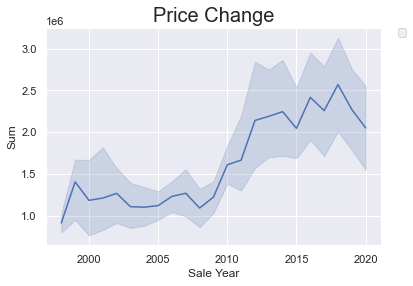

In [26]:
# median price change accroding to the neigborhood

tama_potetial_list = ['Karmelia']#["Rommema", "Ramat Begin", "Ramat_golda", 'Karmelia',"Almogi"]
nadlan_df['tama_potetial'] =nadlan_df.Neighborhood.apply(lambda x: True if x in tama_potetial_list else False)
d = nadlan_df.loc[(nadlan_df.Neighborhood == 'Karmelia')&(nadlan_df.Rooms >= 4)&(nadlan_df.Rooms <= 6)].groupby(['Rooms','Neighborhood', 'Sale Year']).median().reset_index()

# sns.set_style("darkgrid")
sns.set(font_scale=1)
chart = sns.lineplot('Sale Year', 'Sum', data=d);
# plt.xticks(rotation=70);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

chart.set_title("Price Change", fontsize=20);

### Is the neighborhood is demand?
To know if a neighborhood truly desirabile we find contradictions - higher prices despite worse apartment features. Such s cute analysis is to compare medain build year vs. price. As we just saw - old appartments are less desirable than new ones. If the medain building year is old but the price is still hight then it might suggest that the neighborhood is in high demand. 

The following analysis controls room number but not floor or size. It is for 4-bedroom apartments.

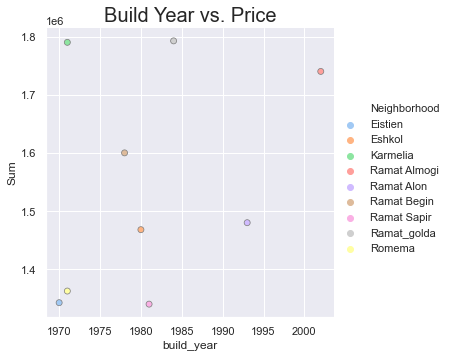

In [27]:


# sns.set(font_scale=1.5);
rooms = 4 
d = nadlan_df.loc[(nadlan_df.Rooms == rooms) & (nadlan_df['Sale Year'] >= year)].groupby(['Neighborhood']).median().reset_index()
g = sns.relplot(x="build_year", y="Sum", hue="Neighborhood", palette="pastel", edgecolor = 'grey', data=d);

plt.title("Build Year vs. Price",fontsize=20);
plt.savefig('BuildYea_Price.png', dpi=200, bbox_inches="tight")

# plt.xticks(rotation=70);

#### Beyond mean - Variation in old buildings
For old buildings, we can't really say what is the condition of the apartment. Furthermore, added elvators, balconies and shelder may not be regestered. This could bias the prices upwars. 

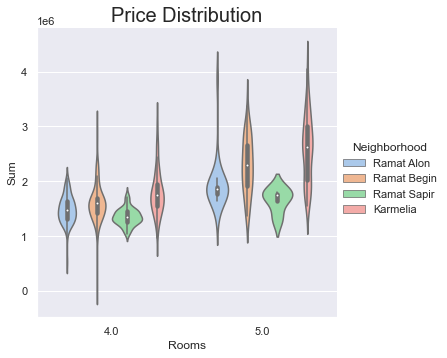

In [28]:
d = nadlan_df.loc[ (nadlan_df['Sale Year'] >= year)& ~(nadlan_df.tama_building) &(nadlan_df['Sale Year'] >= year) & ((nadlan_df['Rooms'] == 4)| (nadlan_df['Rooms'] == 5)) & (nadlan_df['Enterance Floor'] >= 0) & ((nadlan_df['Neighborhood'] == "Ramat Sapir")|(nadlan_df['Neighborhood'] == "Ramat Alon")| (nadlan_df['Neighborhood'] == "Ramat Begin") | (nadlan_df['Neighborhood'] == "Karmelia"))]

g = sns.catplot(x="Rooms", y="Sum", hue="Neighborhood", data=d, kind="violin", palette = 'pastel')

plt.title("Price Distribution",fontsize=20, y=1.1);

plt.savefig('Distribution_of_Prices_for_4Bedroom_Apartments.png', dpi=200, bbox_inches="tight")


## Nearest Neighbors - Similar Deals
So, after getting a general sense of the prices in the area, you might want to get a more specific estiamte for specific apartment. As we've seen before, we simply can't deduce the an exact estimate based on *Nadlan.Gov*'s data alone. A simple mitigation is to find 3-2 similar apartments, or *Nearest Neighbors* :) and evaluate the differences. Some of the differences can be spotted from the dataset. But others should be found in alternative ways, like checking the municipality's engeeniring department site (house plans are **online**) or physically looking at the building.You might not know in what condition they were in but one can guess based on what you learned so far. It's still not perfect but it's much closer.

##### K-NN
The following fuction suggest the following calculation for similarity between apartments. You may have different priorites and change it. Currently, the function considers:
* Neighborhood
* Bedrooms
* Address
* Size
* New\second hand

In [29]:
# Find 3 Nearest Neighbors

def similary(row, params={}):
    
    w1=15
    w2=5
    score = 0
    if params != {}:
    
    # same neighborhood
        score += w1 if params['Neighborhood'] == row.Neighborhood else 0
        
    # same street - disregardes numbers
        if score > 0: # same neighborhood
            if row.Address != '':
                row_Address = row.Address.split(' ')
                Address = params["Address"].split(' ')
                stop = -1 if Address[-1].isnumeric() else len(Address)

                matches = [s == row_Address[i] for i,s in enumerate(Address[:stop])]
                score += w1 if len(Address[:stop]) == sum(matches) else 0

        if params['Rooms'] == row.Rooms:
             score += w1
        elif abs(params['Rooms'] - row.Rooms) < 1:
            score += w1*0.5
        elif abs(params['Rooms'] - row.Rooms) <= 1:
            score += w2*0.75
            
        score += w1 if params['is_new'] == row.is_new else 0
            
        # size
        score += w2 if abs(params['Size (m^2)'] - row['Size (m^2)']) <= 10 else w2*0.5 if abs(params['Size (m^2)'] - row['Size (m^2)']) <= 20 else 0 
    else:
        print("No params")
        
    return score

In [30]:
# run over frame and extact 3 best

params = {'Neighborhood':'Ramat Alon', 'Address':'יגאל אלון 4', 'is_new':False, 'Rooms':4, 'Size (m^2)':100}

year =2015 # last 5 years prices
d = nadlan_df.loc[nadlan_df['Sale Year'] >= year].copy()
d['Sim'] = d.apply(similary, params=params, axis=1)
d.sort_values(by=['Sim'],ascending=False).head(3)

,Building Hight,Apartment Year,שנת בנייה מבנה,Date,Address,Lot,Type,Rooms,Floor,Size (m^2),...,Enterance Floor,קומות בדירה,Sale Year,build_year,is_new,tall,tama_apartment,tama_building,tama_potetial,Sim
62,18.0,2008,2008,2018-08-19,יגאל אלון 35,12695-43-100,דירה בבית קומות,4.0,תשיעית,104.00,...,9,1,2018,2008,False,True,False,False,False,65.0
154,18.0,2009,2009,2016-03-28,יגאל אלון 35,12695-43-51,דירה בבית קומות,4.0,ארבע עשרה,96.15,...,14,1,2016,2009,False,True,False,False,False,65.0
167,12.0,2008,2008,2015-02-11,יגאל אלון 39,12695-43-149,דירה בבית קומות,4.0,שלישית,108.58,...,3,1,2015,2008,False,True,False,False,False,65.0
